In [ ]:
!nvidia-smi

Tue Aug 31 16:01:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import os
import copy
import torchvision
import pandas as pd
import albumentations
import glob
import cv2
import random
import torch.nn.functional as F

from pathlib import Path
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from itertools import chain

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
torch.use_deterministic_algorithms(True)

def set_seed(seed=89012):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/ML4H/data/original_resized.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Mole_only/train/NV/ISIC_3529572.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3530337.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3530902.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3531277.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3534791.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3535007.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3537089.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3537191.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3542273.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3545972.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3551438.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3551661.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3551685.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3552245.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_3556570.jpg  
  inflating: /content/Mole_only/train/NV/ISIC_355

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=43a2099b98df73e4d8a8a782424c6d1b3215906c06f6c8ac32b79a465218d47c
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
class Effnet(nn.Module):

    def __init__(self):
        self.meta_features = 3
        self.effnet_features = 2048
        self.meta_out = 8 # 16, 64
        self.output_classes = 8
        super(Effnet, self).__init__()

        #Initialize Efficientnet
        self.model = EfficientNet.from_pretrained('efficientnet-b5')
        for param in self.model.parameters():
          param.requires_grad = True
        self.model._fc = nn.Identity() 
        self.model._swish = nn.Identity() 

        #Initialize Meta-net
        self.meta = nn.Sequential(
                nn.Linear(self.meta_features, self.meta_out),
                nn.BatchNorm1d(self.meta_out),
                nn.SiLU() 
            )
        
        #Initialize concatenated-net
        self.in_ch = self.effnet_features + self.meta_out
        self.final_fc = nn.Sequential(nn.Linear(self.in_ch, self.output_classes),
                                      nn.SiLU()
                                      )     
        
        #Remove below layers:
        #self.model._fc = nn.Linear(2048, 1000)
        #in_ch = self.enet.classifier.in_features                        
        #self.enet.classifier = nn.Identity() # Add Swish


    def forward(self, x, x_meta):
        #x = self.extract(x).squeeze(-1).squeeze(-1)
        x = self.model(x)
        x_meta = F.normalize(x_meta)
        x_meta = self.meta(x_meta)
        x = torch.cat((x, x_meta), dim=1) #Concatenate EffNet output and metanet output

        out = self.final_fc(x)

        return out


In [ ]:
model = Effnet()
#Moves model to GPU
device = torch.device("cuda")
model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


Effnet(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_proje

In [ ]:
transforms_train = albumentations.Compose([
        albumentations.Rotate (limit=360, always_apply=True),
        albumentations.HorizontalFlip(p=0.5),
        #albumentations.CLAHE(clip_limit=2.0, p=0.5),
    ])
#transforms_val = albumentations.CLAHE(clip_limit=2.0, always_apply=True)

In [ ]:
train_csv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML4H/train_meta.csv')
#train_csv = train_raw.sample(frac=1).reset_index(drop=True)
val_csv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML4H/val_meta.csv')
#val_csv = val_raw.sample(frac=1).reset_index(drop=True)

In [ ]:
TR_IMG_PATH = '/content/Mole_only/train'

class TrainMelanomaDataset(Dataset):
    def __init__(self, csv, transform=None):
        self.csv = csv
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        label = row['Class']
        wid = row['Width']
        hei = row['Height']
        size = row['Size']
        name = row['Name']

        if label == 'AK':
            lab = 0
        elif label == 'BCC':
            lab = 1
        elif label == 'BKL':
            lab = 2
        elif label == 'DF':
            lab = 3
        elif label == 'MEL':
            lab = 4
        elif label == 'NV':
            lab = 5
        elif label == 'SCC':
            lab = 6
        else:
            lab = 7
          
        image = cv2.imread(TR_IMG_PATH + f'/{label}/' + name + '.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res = self.transform(image=image)
        image = res['image']
        image = image.transpose(2,0,1)

        return torch.from_numpy(image).float(), torch.tensor(lab), torch.tensor([wid, hei, size], dtype=torch.float32)

In [ ]:
VAL_IMG_PATH = '/content/Mole_only/val'

class ValMelanomaDataset(Dataset):
    def __init__(self, csv, transform=None):
        self.csv = csv
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        label = row['Class']
        wid = row['Width']
        hei = row['Height']
        size = row['Size']
        name = row['Name']

        if label == 'AK':
            lab = 0
        elif label == 'BCC':
            lab = 1
        elif label == 'BKL':
            lab = 2
        elif label == 'DF':
            lab = 3
        elif label == 'MEL':
            lab = 4
        elif label == 'NV':
            lab = 5
        elif label == 'SCC':
            lab = 6
        else:
            lab = 7
          
        image = cv2.imread(VAL_IMG_PATH + f'/{label}/' + name + '.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #res = self.transform(image=image)
        #image = res['image']
        image = image.transpose(2,0,1)

        return torch.from_numpy(image).float(), torch.tensor(lab), torch.tensor([wid, hei, size], dtype=torch.float32)
      

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
      TrainMelanomaDataset(train_csv, transforms_train),
      batch_size=batch_size,
      num_workers=2,
      worker_init_fn=seed_worker,
      generator=g,
      shuffle=True
  )
val_loader = torch.utils.data.DataLoader(
      ValMelanomaDataset(val_csv),
      batch_size=batch_size,
      num_workers=2,
      worker_init_fn=seed_worker,
      generator=g,
      shuffle=True
  )

In [ ]:
#copied from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

NUM_EPOCHS = 20 #Adjust number of epochs
SAVEPATH_BEST = '/content/drive/MyDrive/Colab Notebooks/orig_resized_89012.pth' #Change model name
use_amp = True

#Criteria for training, Use weight decay as L2 regularization 

#weight_decay=1e-4

lr = 3e-5 # Learning rate
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) # Define optimizer
scaler = torch.cuda.amp.GradScaler(enabled=use_amp) # For mixed precision
criterion = nn.CrossEntropyLoss().cuda() # Define loss function

def train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    score_hist = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print(f'{phase} phase:')
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            all_labels = []
            all_output = []
            all_prob = []
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, meta in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                meta = meta.to(device).squeeze()
                labels = labels.to(device)

                # zero the parameter gradientslauren
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast(enabled=use_amp):
                      # Get model outputs and calculate loss
                      outputs = model(inputs, meta)
                      output_proba = F.softmax(outputs, dim=1)
                      loss = criterion(outputs, labels)
                      _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                      scaler.scale(loss).backward()
                      scaler.step(optimizer)
                      scaler.update()
                

                if phase == 'val':
                  all_prob.extend(output_proba.cpu().tolist())
                  all_labels.extend(labels)
                  all_output.extend(preds)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
              scheduler.step()
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            

            if phase == 'val':
              all_labels = torch.tensor(all_labels)
              labels_binarized = label_binarize(all_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7])
              prob_arr = np.array(all_prob)
              score = metrics.roc_auc_score(labels_binarized, prob_arr, average=None)
              mel_score = score[4]
   
            if phase == 'val':
              print('{} Loss: {:.4f} Acc: {:.4f} AUC:{:.4f} '.format(phase, epoch_loss, epoch_acc, mel_score))
            else:
              print('{} Loss: {:.4f} Acc: {:.4f} '.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and mel_score > best_auc: #Metric for best model selection
                best_auc = mel_score
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'{SAVEPATH_BEST}')
            if phase == 'val':
                val_acc_history.append(epoch_acc.cpu())
                val_loss_history.append(epoch_loss)
                score_hist.append(mel_score)
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu())
                train_loss_history.append(epoch_loss)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best AUC score: {:4f}'.format(best_auc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history, score_hist

In [ ]:

dataloaders = {'train':train_loader, 'val':val_loader}
model, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist, score_hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

Adjusting learning rate of group 0 to 3.0000e-05.
Epoch 0/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.8230 Acc: 0.7314 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5828 Acc: 0.7955 AUC:0.8622 
Epoch 1/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.6223 Acc: 0.7879 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5299 Acc: 0.8116 AUC:0.8849 
Epoch 2/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.5427 Acc: 0.8118 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4824 Acc: 0.8258 AUC:0.9071 
Epoch 3/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.4856 Acc: 0.8298 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4953 Acc: 0.8359 AUC:0.9114 
Epoch 4/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.4536 Acc: 0.8394 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4832 Acc: 0.8384 AUC:0.9165 
Epoch 5/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.4224 Acc: 0.8505 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4667 Acc: 0.8434 AUC:0.9239 
Epoch 6/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.3873 Acc: 0.8628 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4544 Acc: 0.8475 AUC:0.9231 
Epoch 7/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.3552 Acc: 0.8733 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4816 Acc: 0.8449 AUC:0.9225 
Epoch 8/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-05.
train Loss: 0.3361 Acc: 0.8785 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4771 Acc: 0.8490 AUC:0.9233 
Epoch 9/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.3062 Acc: 0.8877 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4879 Acc: 0.8434 AUC:0.9266 
Epoch 10/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.2698 Acc: 0.9046 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4980 Acc: 0.8505 AUC:0.9249 
Epoch 11/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.2414 Acc: 0.9137 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5199 Acc: 0.8475 AUC:0.9252 
Epoch 12/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.2278 Acc: 0.9177 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5308 Acc: 0.8455 AUC:0.9264 
Epoch 13/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.2145 Acc: 0.9231 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5357 Acc: 0.8460 AUC:0.9286 
Epoch 14/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.1997 Acc: 0.9286 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5385 Acc: 0.8495 AUC:0.9254 
Epoch 15/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.1929 Acc: 0.9329 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5814 Acc: 0.8444 AUC:0.9152 
Epoch 16/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.1812 Acc: 0.9337 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5625 Acc: 0.8535 AUC:0.9271 
Epoch 17/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.1772 Acc: 0.9376 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5883 Acc: 0.8515 AUC:0.9236 
Epoch 18/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5000e-05.
train Loss: 0.1626 Acc: 0.9433 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5791 Acc: 0.8571 AUC:0.9302 
Epoch 19/19
----------
train phase:


  0%|          | 0/992 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5000e-06.
train Loss: 0.1539 Acc: 0.9447 
val phase:


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.6083 Acc: 0.8434 AUC:0.9277 
Training complete in 370m 50s
Best AUC score: 0.930191


In [ ]:
#Load model, only run when loading previous model. Run the model architecture above first.
LOADPATH='/content/drive/MyDrive/Firefox/mole_dilated10_seed111111_8_3.pth'
model.load_state_dict(torch.load(LOADPATH))
model.to(device)

Effnet(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_proje

In [ ]:
criterion = nn.CrossEntropyLoss().cuda() # Define loss function

In [ ]:
#For Clahe
test_csv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML4H/test_meta.csv')

In [ ]:
TEST_IMG_PATH = '/content/Mole_only_dilated_10_456/test'

class TestMelanomaDataset(Dataset):
    def __init__(self, csv, transform=None):
        self.csv = csv
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        label = row['Class']
        wid = row['Width']
        hei = row['Height']
        size = row['Size']
        name = row['Name']

        if label == 'AK':
            lab = 0
        elif label == 'BCC':
            lab = 1
        elif label == 'BKL':
            lab = 2
        elif label == 'DF':
            lab = 3
        elif label == 'MEL':
            lab = 4
        elif label == 'NV':
            lab = 5
        elif label == 'SCC':
            lab = 6
        else:
            lab = 7
          
        image = cv2.imread(TEST_IMG_PATH + f'/{label}/' + name + '.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #res = self.transform(image=image)
        #image = res['image']
        image = image.transpose(2,0,1)

        return torch.from_numpy(image).float(), torch.tensor(lab), torch.tensor([wid, hei, size], dtype=torch.float32)
      

In [ ]:
batch_size = 16

test_loader = torch.utils.data.DataLoader(
      TestMelanomaDataset(test_csv),
      batch_size=batch_size,
      num_workers=2,
      shuffle=True
  )

In [ ]:
from tqdm.notebook import tqdm

with torch.no_grad():
  running_loss = 0.0
  running_corrects = 0
  model.eval()
  prediction = []
  label = []
  pred = []
  for inputs, labels, meta in tqdm(test_loader): 
    inputs = inputs.to(device)
    meta = meta.to(device).squeeze()
    labels = labels.to(device)
    outputs = model(inputs, meta)
    output_proba = F.softmax(outputs, dim=1)
    _ , preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    prediction.extend(output_proba.cpu().tolist())
    pred.extend(preds.cpu().tolist())
    label.extend(labels.cpu().tolist())

  epoch_loss = running_loss / len(test_loader.dataset)
  epoch_acc = running_corrects.double() / len(test_loader.dataset)
  print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

  0%|          | 0/125 [00:00<?, ?it/s]

Test Loss: 0.5203 Acc: 0.8390


In [ ]:
#Create confusion matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(label, pred) 

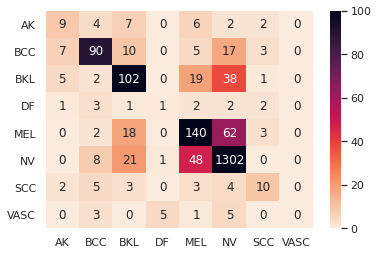

In [ ]:
#Plot confusion matrix
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(mat,xticklabels=['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'],yticklabels=['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'], annot=True, fmt='n',vmax =100, cmap = sns.cm.rocket_r)
plt.yticks(rotation=0) 
plt.show()

In [ ]:
#Create list of probabilities for the correct class
#Matrix of n*k, vector of n with indexes (0 to k)
pred_arr = np.array(prediction)
pred_proba = pred_arr[np.arange(pred_arr.shape[0]), pred]

In [ ]:
#AUROC score for each class
from sklearn.metrics import roc_auc_score
labels_binarized = label_binarize(label, classes=[0, 1, 2, 3, 4, 5, 6, 7])
#output_binarized = label_binarize(pred, classes=[0, 1, 2, 3, 4, 5, 6, 7])
auc_sc = roc_auc_score(labels_binarized, pred_arr, average=None)
print(f'AK AUC: {auc_sc[0]:.4f} \nBCC AUC: {auc_sc[1]:.4f} \nBKL AUC: {auc_sc[2]:.4f} \nDF AUC: {auc_sc[3]:.4f} \
\nMEL AUC: {auc_sc[4]:.4f} \nNV AUC: {auc_sc[5]:.4f} \nSCC AUC: {auc_sc[6]:.4f} \nVASC AUC: {auc_sc[7]:.4f}')

AK AUC: 0.9651 
BCC AUC: 0.9818 
BKL AUC: 0.9485 
DF AUC: 0.9688 
MEL AUC: 0.9175 
NV AUC: 0.9586 
SCC AUC: 0.9439 
VASC AUC: 0.9490


In [ ]:
#AUROC score for each class
from sklearn.metrics import roc_auc_score
pred_arr = np.hstack((pred_arr[:,1:6], pred_arr[:,7].reshape((-1,1))))
labels_binarized = label_binarize(label, classes=[1, 2, 3, 4, 5, 7])
#output_binarized = label_binarize(pred, classes=[0, 1, 2, 3, 4, 5, 6, 7])
auc_sc = roc_auc_score(labels_binarized, pred_arr, average=None)

print(f'BCC AUC: {auc_sc[0]:.4f} \nBKL AUC: {auc_sc[1]:.4f} \nDF AUC: {auc_sc[2]:.4f} \
\nMEL AUC: {auc_sc[3]:.4f} \nNV AUC: {auc_sc[4]:.4f} \nVASC AUC: {auc_sc[5]:.4f}')


BCC AUC: 0.7298 
BKL AUC: 0.7163 
DF AUC: 0.8887 
MEL AUC: 0.7305 
NV AUC: 0.7503 
VASC AUC: 0.6751


In [ ]:
#MEDNODE AUROC score for each class
from sklearn.metrics import roc_auc_score
pred_arr = pred_arr[:,4:6]
labels_binarized = label_binarize(label, classes=[4,5])
labels_1 = 1- labels_binarized
labels_bin = np.hstack((labels_1, labels_binarized))
#output_binarized = label_binarize(pred, classes=[0, 1, 2, 3, 4, 5, 6, 7])

auc_sc = roc_auc_score(labels_bin, pred_arr, average=None)
print(f'MEL AUC: {auc_sc[0]:.4f} \nNV AUC: {auc_sc[1]:.4f}' )


(170, 2)
(170, 2)
[0.88171429 0.86985714]
MEL AUC: 0.8817 
NV AUC: 0.8699
